In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')

In [3]:
designated_ukc_cls = 3
num_classes = 2
embedding_size=64
bglog = BGLog(save_padded_num_sequences=False, debug=True,  load_from_pkl=True, )
train_test = bglog.get_tensor_train_val_test(ablation=5000, designated_ukc_cls=designated_ukc_cls )
train_data, val_data, test_data = train_test

ablation set to : 5000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
4049 data in class 2 not enough to split into train:4000 and validation:500, adding the entire data as ukc
class 3 is added as ukc
ukc_3:, 500
628 data in class 4 not enough to split into train:4000 and validation:500, adding the entire data as ukc
165 data in class 5 not enough to split into train:4000 and validation:500, adding the entire data as ukc
75 data in class 6 not enough to split into train:4000 and validation:500, adding the entire data as ukc
train: 0    4000
1    4000
Name: label, dtype: int64
val: 0    500
1    500
Name: label, dtype: int64
test: 0    500
1    500
3    500
Name: label, dtype: int64
[[1. 0.]
 [1. 0.]]
some example of labels:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[1. 0.]
 [1. 0.]]

In [4]:
line_encoder = LogLineEncoder(bglog, chars_in_line=64)
logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
hist = ptmodel.fit(train_data, validation_data=val_data, epochs=7) 

vocab_size: 50
Epoch 1/7
250/250 [==============================] - 24s 94ms/step - loss: 0.0247 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - val_loss: 2.4964e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/7
250/250 [==============================] - 23s 93ms/step - loss: 1.1003e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.5709e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/7
250/250 [==============================] - 23s 93ms/step - loss: 2.9041e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6568e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/7
250/250 [==============================] - 23s 93ms/step - loss: 1.7834e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1410e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/7
250/250 [==============================] - 23s 

In [ ]:
# training and recalculating the centroids in each epoch

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.36it/s]


epoch: 1/50, train_loss: 4.657820701599121, eval_score: 0.5


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.46it/s]


epoch: 2/50, train_loss: 4.657818794250488, eval_score: 0.48433672811653994


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.49it/s]


epoch: 3/50, train_loss: 4.657764434814453, eval_score: 0.9543718455872323


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.47it/s]


epoch: 4/50, train_loss: 4.657783508300781, eval_score: 0.9543718455872323


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.13it/s]


epoch: 5/50, train_loss: 4.657760143280029, eval_score: 0.48433672811653994


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.46it/s]


epoch: 6/50, train_loss: 4.657793045043945, eval_score: 0.0


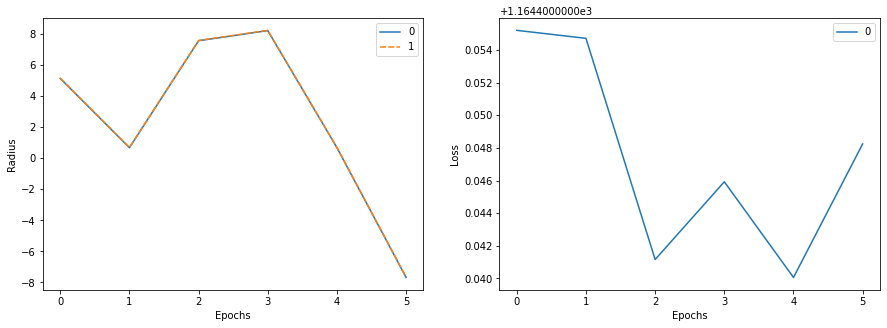

In [7]:
oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
_, _ = oset.train(train_data, epochs=50, lr_rate=3, wait_patient=3,)

In [ ]:
oset.plot_radius_chages()
preds = oset.openpredict(oset.features)
y_true, y_pred, _ = oset.evaluate(train_data)

ablation set to : 5000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
4049 data in class 2 not enough to split into train:4000 and validation:500, adding the entire data as ukc
class 3 is added as ukc
ukc_3:, 500
628 data in class 4 not enough to split into train:4000 and validation:500, adding the entire data as ukc
165 data in class 5 not enough to split into train:4000 and validation:500, adding the entire data as ukc
75 data in class 6 not enough to split into train:4000 and validation:500, adding the entire data as ukc
train: 0    4000
1    4000
Name: label, dtype: int64
val: 0    500
1    500
Name: label, dtype: int64
test: 0    500
1    500
3    500
Name: label, dtype: int64
[[1. 0.]
 [1. 0.]]
some example of labels:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[1. 0.]
 [1. 0.]]

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.37it/s]


epoch: 1/50, train_loss: 9.517409324645996, eval_score: 0.4991861775385001


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.43it/s]


epoch: 2/50, train_loss: 9.517468452453613, eval_score: 0.4994994994994995


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.37it/s]


epoch: 3/50, train_loss: 9.517437934875488, eval_score: 0.4994994994994995


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.32it/s]


epoch: 4/50, train_loss: 9.517426490783691, eval_score: 0.4994994994994995


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.26it/s]


epoch: 5/50, train_loss: 9.517449378967285, eval_score: 0.4994994994994995


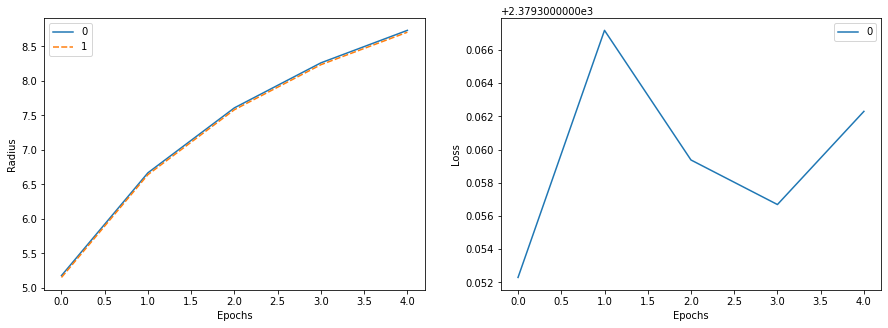

In [8]:
designated_ukc_cls = 3
num_classes = 2
embedding_size=8
lr_rate=3
bglog = BGLog(save_padded_num_sequences=False, debug=True,  load_from_pkl=True, )
train_test = bglog.get_tensor_train_val_test(ablation=5000, designated_ukc_cls=designated_ukc_cls )
train_data, val_data, test_data = train_test
line_encoder = LogLineEncoder(bglog, chars_in_line=64)
logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
hist = ptmodel.fit(train_data, validation_data=val_data, epochs=7)
oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
_, _ = oset.train(train_data, epochs=50, lr_rate=lr_rate, wait_patient=3,)


ablation set to : 5000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
4049 data in class 2 not enough to split into train:4000 and validation:500, adding the entire data as ukc
class 3 is added as ukc
ukc_3:, 500
628 data in class 4 not enough to split into train:4000 and validation:500, adding the entire data as ukc
165 data in class 5 not enough to split into train:4000 and validation:500, adding the entire data as ukc
75 data in class 6 not enough to split into train:4000 and validation:500, adding the entire data as ukc
train: 0    4000
1    4000
Name: label, dtype: int64
val: 0    500
1    500
Name: label, dtype: int64
test: 0    500
1    500
3    500
Name: label, dtype: int64
[[1. 0.]
 [1. 0.]]
some example of labels:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[1. 0.]
 [1. 0.]]

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.05it/s]


epoch: 1/50, train_loss: 4.325394153594971, eval_score: 0.5


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.03it/s]


epoch: 2/50, train_loss: 4.32535982131958, eval_score: 0.42404607631389485


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.02it/s]


epoch: 3/50, train_loss: 4.325413227081299, eval_score: 0.9544462629569013


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.03it/s]


epoch: 4/50, train_loss: 4.325409889221191, eval_score: 0.9544462629569013


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  6.98it/s]


epoch: 5/50, train_loss: 4.325465202331543, eval_score: 0.42404607631389485


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.26it/s]


epoch: 6/50, train_loss: 4.325425624847412, eval_score: 0.9548923412373945


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.34it/s]


epoch: 7/50, train_loss: 4.325436592102051, eval_score: 0.9549666167052732


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.36it/s]


epoch: 8/50, train_loss: 4.325387001037598, eval_score: 0.9550408719346049


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.26it/s]


epoch: 9/50, train_loss: 4.325341701507568, eval_score: 0.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.21it/s]


epoch: 10/50, train_loss: 4.325474739074707, eval_score: 0.42404607631389485


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.29it/s]


epoch: 11/50, train_loss: 4.3255085945129395, eval_score: 0.42404607631389485


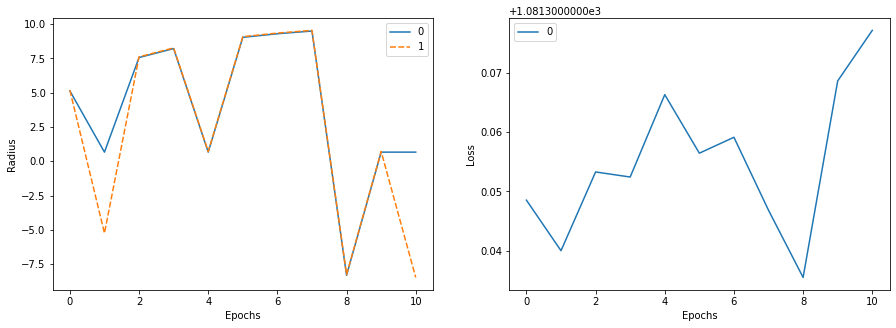

In [9]:
designated_ukc_cls = 3
num_classes = 2
embedding_size=128
lr_rate=3
bglog = BGLog(save_padded_num_sequences=False, debug=True,  load_from_pkl=True, )
train_test = bglog.get_tensor_train_val_test(ablation=5000, designated_ukc_cls=designated_ukc_cls )
train_data, val_data, test_data = train_test
line_encoder = LogLineEncoder(bglog, chars_in_line=64)
logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
hist = ptmodel.fit(train_data, validation_data=val_data, epochs=7)
oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
_, _ = oset.train(train_data, epochs=50, lr_rate=lr_rate, wait_patient=3,)